# Klasifikasi 4 animal

## data acquisition

Data yang digunakan dalam klasifikasi dibagi menjadi data train dan data test. Data train memiliki 4 jenis hewan yaitu cat, deer, dog, dan horse. Sedangkan data test memiliki gambar-gambar yang akan digunakan untuk klasifikasi model yang dibuat.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/4-animal-classification/Sample_submission.csv
/kaggle/input/4-animal-classification/test/test/623.jpg
/kaggle/input/4-animal-classification/test/test/208.jpg
/kaggle/input/4-animal-classification/test/test/473.jpg
/kaggle/input/4-animal-classification/test/test/333.jpg
/kaggle/input/4-animal-classification/test/test/537.jpg
/kaggle/input/4-animal-classification/test/test/45.jpg
/kaggle/input/4-animal-classification/test/test/369.jpg
/kaggle/input/4-animal-classification/test/test/56.jpg
/kaggle/input/4-animal-classification/test/test/654.jpg
/kaggle/input/4-animal-classification/test/test/89.jpg
/kaggle/input/4-animal-classification/test/test/20.jpg
/kaggle/input/4-animal-classification/test/test/275.jpg
/kaggle/input/4-animal-classification/test/test/212.jpg
/kaggle/input/4-animal-classification/test/test/239.jpg
/kaggle/input/4-animal-classification/test/test/58.jpg
/kaggle/input/4-animal-classification/test/test/150.jpg
/kaggle/input/4-animal-classification/test/test/6

**Import library**

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Inisialisasi variable global yang diperlukan**

In [6]:
# lokasi path
path = '../input/4-animal-classification'
# Parameter input untuk network
dim = (32, 32)
input_shape = (32, 32, 3)
# Batch size
batch_size = 16
# Epoch
epoch = 100

**Visualisasi data**

In [4]:
labels = []
numbers = []
data = {
    'Label of class': [],
    'Count of class': []
}

listdir = os.listdir(f'{path}/train')

for item in listdir:
    labels.append(item)
    numbers.append(len(os.listdir(f'{path}/train/{item}')))

data['Label of class'].extend(labels)
data['Count of class'].extend(numbers)

df = pd.DataFrame(data)
df

,Label of class,Count of class
0,horse,600
1,dog,900
2,cat,700
3,deer,600


<AxesSubplot:xlabel='Label of class', ylabel='Count of class'>

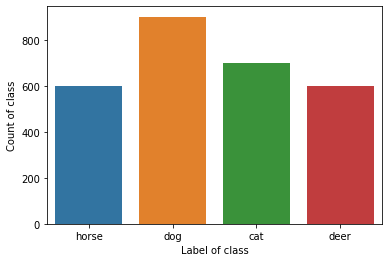

In [5]:
sns.barplot(data=df, x='Label of class', y='Count of class')

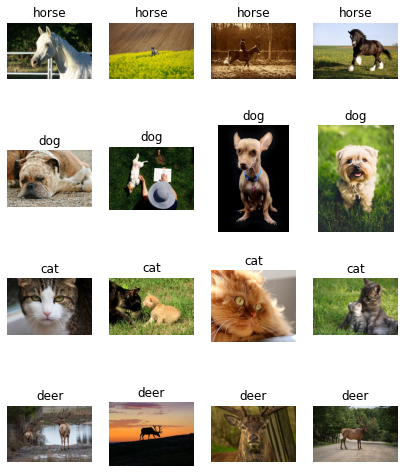

In [6]:
cols = 4
rows = 4
fig = plt.figure(figsize=[2*cols-1, 2.5*rows-1])

for i in range(cols):
    classes = labels[i]
    for j in range(rows):
        random_index = random.randint(0, min(numbers))

        images = os.listdir(f'{path}/train/{classes}')
        image = cv2.imread(f'{path}/train/{classes}/{images[random_index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(rows, cols, i*rows+j+1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(image)
        ax.set_title(classes)

plt.show()


**Prepare data**

Melakukan ekstraksi data yang berupa images/citra digital, yang berasal dari sebuah folder menjadi sebuah array yang dapat dibaca oleh tensorflow. Bentuk penerapan sebagai berikut:
- Rescaling data menjadi 1/255.
- Shearing image skala 0.2
- Zooming image dengan range 0.2
- dan melakukan Horizontal flip

In [7]:
image_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

**Membuat flow data**

Mendefinisikan darimana sumber datanya berasal serta membagi data menjadi data train dan data validation.

In [8]:
train = image_datagen.flow_from_directory(
    f'{path}/train',
    subset='training',
    target_size=dim,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation = image_datagen.flow_from_directory(
    f'{path}/train',
    subset='validation',
    target_size=dim,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

num_class = train.num_classes # jumlah kelas

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


**Transformasi data generator menjadi tf.data**

Mengoptimal dalam pembacaan data yang dilakukan dalam proses training dibandingkan hanya menggunakan generator dari keras itu sendiri. 

In [9]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, input_shape[0], input_shape[1],
                       input_shape[2]], [None, num_class])
    )
    return tf_generator


In [10]:
train_data = tf_data_generator(train, input_shape)
test_data = tf_data_generator(validation, input_shape)

2022-09-20 00:40:50.940804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 00:40:51.045222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 00:40:51.046096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 00:40:51.049040: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Membuat transfer learning model vgg19**

Arsitektur VGG19 merupakan arsitektur yang terdiri dari 47 layer yang menggunakan konsep semakin banyak layer akurasi semakin baik. Convolutional layer menggunakan filter 3 × 3 dengan jumlah dimensi bertambah di setiap layer. Dimensi yang digunakan pada filter adalah 3, 64, 128, 256, dan 512.


In [2]:
import tensorflow as tf
# base model
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(35,35,3),
    pooling='max',
    classes=4,
    classifier_activation='softmax'
)


58900480/58889256 [==============================] - 103s 2us/step


**Membuat arsitektur model**

In [12]:
def my_model():
  model = Sequential()
  
  model.add(base_model)

  model.add(Flatten())
  
  model.add(Dense(2048, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2048, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))
  
  model.add(Dense(num_class, activation='softmax'))

  return model


In [3]:
# inisialisasi variable model
model = my_model()

In [14]:
model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2048)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0

**Training data**

In [15]:
history = model.fit(
    x=train,
    steps_per_epoch=64,
    validation_data=validation,
    validation_steps=32,
    shuffle=True,
    epochs=epoch,
    verbose=1
)

2022-09-20 00:40:55.535495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-09-20 00:40:57.660086: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


64/64 [==============================] - 27s 297ms/step - loss: 1.3822 - accuracy: 0.2705 - val_loss: 1.3705 - val_accuracy: 0.3320
Epoch 2/100
64/64 [==============================] - 14s 213ms/step - loss: 1.3764 - accuracy: 0.2998 - val_loss: 1.3712 - val_accuracy: 0.3203
Epoch 3/100
64/64 [==============================] - 12s 193ms/step - loss: 1.3635 - accuracy: 0.3262 - val_loss: 1.3511 - val_accuracy: 0.3301
Epoch 4/100
64/64 [==============================] - 12s 191ms/step - loss: 1.3591 - accuracy: 0.3164 - val_loss: 1.3321 - val_accuracy: 0.3242
Epoch 5/100
64/64 [==============================] - 11s 178ms/step - loss: 1.3463 - accuracy: 0.3223 - val_loss: 1.3532 - val_accuracy: 0.4219
Epoch 6/100
64/64 [==============================] - 11s 179ms/step - loss: 1.3109 - accuracy: 0.3311 - val_loss: 1.2781 - val_accuracy: 0.4258
Epoch 7/100
64/64 [==============================] - 12s 185ms/step - loss: 1.3126 - accuracy: 0.3447 - val_loss: 1.3005 - val_accuracy: 0.4316
Epoc

**Evaluasi**

In [16]:
model.evaluate(validation)

35/35 [==============================] - 4s 108ms/step - loss: 1.3912 - accuracy: 0.6071


[1.3911799192428589, 0.6071428656578064]

Hasil evaluasi dari model yang didapat menggunakan data validation bisa dikatakan kurang baik, karena pada training menghasilkan model yang overfitting.

**Visualisasi hasil dari training dan evaluasi model**

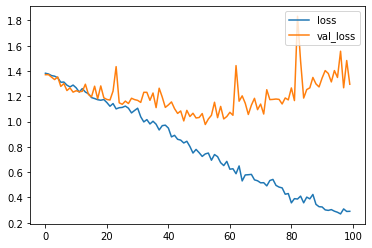

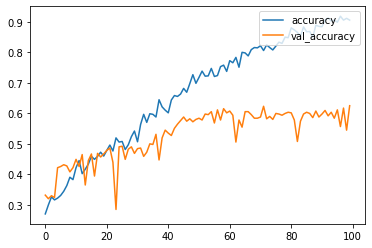

In [17]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')
plt.show()


**prepare untuk submit predictions**

In [18]:
# inisialisasi path
sub_csv = f'{path}/Sample_submission.csv'
path_test = f'{path}/test/test'

In [19]:
# melihat sample data yang akan disubmit
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head()

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


**Proses testing dengan data test**

In [20]:
from tensorflow.keras.preprocessing.image import load_img

labels = []

for i in image_id:
    image = load_img(f'{path_test}/{str(i)}.jpg', target_size=[32, 32])
    img = np.array(image)
    img = img/255.0
    img = img.reshape(1, 32, 32, 3)
    label = model.predict(img)
    label_id = label[0].tolist()

    labels.append(label_id.index(max(label_id)))


In [21]:
# hasil prediksi yang diperoleh
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,2
2,3,0
3,4,3
4,5,2
5,6,1
6,7,1
7,8,2
8,9,3
9,10,2


In [22]:
# simpan data prediksi
df_sub.to_csv('submission_file.csv',index=False)

## Kesimpulan

- Arsitektur VGG19 merupakan salah satu  arsitektur  yang dapat digunakan untuk mengklasifikasi beberapa gambar.Pada percobaan ini arsitekture vgg19 ternyata menghasilkan akurasi yang bisa dikatakan kurang baik, karena pada training menghasilkan model yang overfitting.

- Model yang overfitting dapat diperbaiki, salah satunya dengan mengurangi epochs. Namun mengurangi epochs dapat membuat model menjadi underfitting. Underfitting sendiri dapat diperbaiki, salah satunya dengan membesarkan piksel gambar input.
